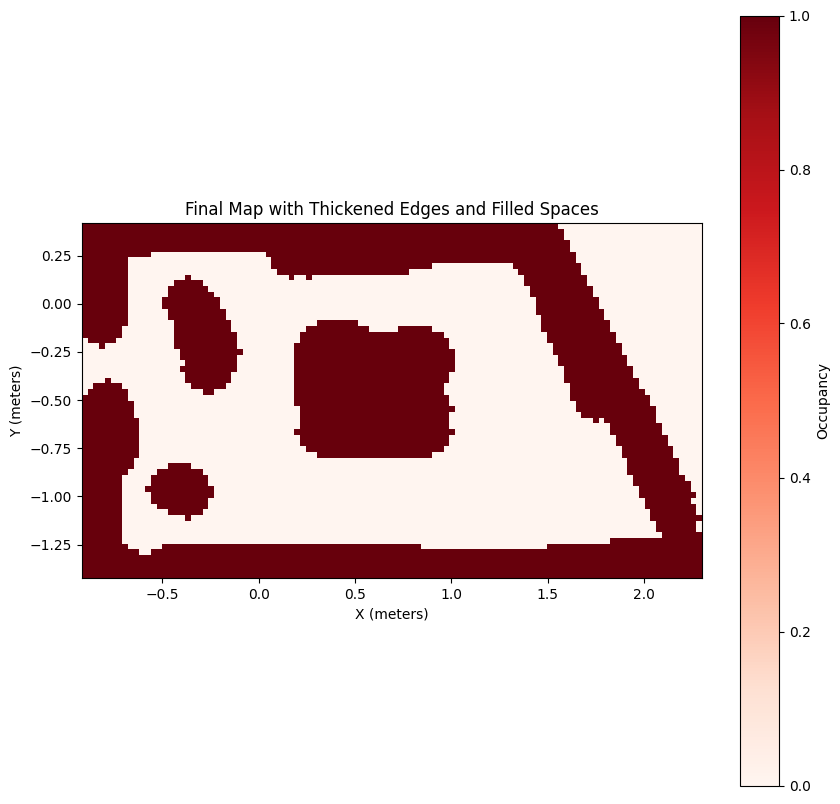

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes

# Load data from files
df1 = pd.read_csv('usdata.csv')
df2 = pd.read_csv('usdata2.csv')

x1, y1 = df1['x'].values, df1['y'].values
x2, y2 = df2['x'].values, df2['y'].values

# Transformation parameters for data2
translation_vector_2 = np.array([1.0, 0.0])  # Shift data2 x-coordinate to the left by 1 unit

# Apply the translation to data2
transformed_x2 = x2 + translation_vector_2[0]
transformed_y2 = y2 + translation_vector_2[1]

# Combine all points into a single dataset
all_x = np.concatenate((x1, transformed_x2))
all_y = np.concatenate((y1, transformed_y2))

# Determine the bounds of the grid
x_min, x_max = np.min(all_x), np.max(all_x)
y_min, y_max = np.min(all_y), np.max(all_y)

# Define the grid resolution
resolution = 0.03  # Size of each grid cell in meters

# Calculate grid dimensions based on bounds and resolution
grid_width = int(np.ceil((x_max - x_min) / resolution))
grid_height = int(np.ceil((y_max - y_min) / resolution))

# Initialize the grid map with zeros (free space)
grid_map = np.zeros((grid_height, grid_width))

# Helper function to convert coordinates to grid indices
def to_grid_indices(x, y, x_min, y_min, resolution):
    grid_x = int((x - x_min) / resolution)
    grid_y = int((y - y_min) / resolution)
    return grid_x, grid_y

# Populate the grid map with points from all slices
for x, y in zip(all_x, all_y):
    grid_x, grid_y = to_grid_indices(x, y, x_min, y_min, resolution)
    if 0 <= grid_x < grid_width and 0 <= grid_y < grid_height:
        grid_map[grid_y, grid_x] = 1  # Mark as occupied

# Add a filled line to connect two points
line_x = np.linspace(0.33, 0.898, num=50)
line_y = np.full_like(line_x, -0.66)

# Populate the map with the connecting line
for x, y in zip(line_x, line_y):
    grid_x, grid_y = to_grid_indices(x, y, x_min, y_min, resolution)
    if 0 <= grid_x < grid_width and 0 <= grid_y < grid_height:
        grid_map[grid_y, grid_x] = 1

# Function to thicken edges
def thicken_edges(grid_map, radius, resolution):
    radius_in_cells = int(np.ceil(radius / resolution))
    thickened_map = grid_map.copy()

    for y in range(grid_map.shape[0]):
        for x in range(grid_map.shape[1]):
            if grid_map[y, x] == 1:  # If the cell is occupied
                for dx in range(-radius_in_cells, radius_in_cells + 1):
                    for dy in range(-radius_in_cells, radius_in_cells + 1):
                        if dx**2 + dy**2 <= radius_in_cells**2:  # Check within the radius
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < grid_map.shape[1] and 0 <= ny < grid_map.shape[0]:
                                thickened_map[ny, nx] = 1
    return thickened_map

# Thicken the edges
edge_thickness = 0.1  # Thickness in meters
thickened_map = thicken_edges(grid_map, edge_thickness, resolution)

# Fill inner spaces within obstacles
filled_map = binary_fill_holes(thickened_map).astype(int)

# Visualize the final map
plt.figure(figsize=(10, 10))
plt.imshow(filled_map, cmap='Reds', origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.title("Final Map with Thickened Edges and Filled Spaces")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.colorbar(label="Occupancy")
plt.show()
print(filled_map)